# Firing Rate Comparisons SWI and SWISIN experiments

In [1]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
def get_fr_reduction_info(subject, exp):
    # ----------------------------------------- subject_info + Hypno -----------------------------------------
    h = acr.io.load_hypno_full_exp(subject, exp)
    si = acr.info_pipeline.load_subject_info(subject)
    params = acr.info_pipeline.subject_params(subject)
    stores = params['time_stores']
    sort_ids = [f'{exp}-{store}' for store in stores]
    recordings = acr.info_pipeline.get_exp_recs(subject, exp)
    
    # load some temporal information about the rebound, baseline, sd, etc. 
    stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
    reb_start = h.hts(stim_end-pd.Timedelta('15min'), stim_end+pd.Timedelta('1h')).st('NREM').iloc[0].start_time
    if reb_start < stim_end:
        stim_end_hypno = h.loc[(h.start_time<stim_end)&(h.end_time>stim_end)] # if stim time is in the middle of a nrem bout, then it can be the start of the rebound
        if stim_end_hypno.state.values[0] == 'NREM':
            reb_start = stim_end
        else:
            raise ValueError('Rebound start time is before stim end time, need to inspect')
    assert reb_start >= stim_end, 'Rebound start time is before stim end time'
    bl_start_actual = si["rec_times"][f'{exp}-bl']["start"]
    bl_day = bl_start_actual.split("T")[0]
    bl_start = pd.Timestamp(bl_day + "T09:00:00")
    if f'{exp}-sd' in si['rec_times'].keys():
        sd_rec = f'{exp}-sd'
        sd_end = pd.Timestamp(si['rec_times'][sd_rec]['end'])
    else:
        sd_rec = exp
        sd_end = stim_start
    sd_start_actual = pd.Timestamp(si['rec_times'][sd_rec]['start'])
    sd_day = si['rec_times'][sd_rec]['start'].split("T")[0]
    sd_start = pd.Timestamp(sd_day + "T09:00:00")

    # load dataframe of spike info
    df, idf = acr.pl_units.load_spikes_polars(subject, sort_ids, info=True, exclude_bad_units=True)
    
    # get the firing rate info for the both probes in the experiment
    sd_duration = ( sd_end-sd_start_actual ).total_seconds()
    stim_duration = ( stim_end-stim_start ).total_seconds()
    fr_reduction_o = (len(df.prb('NNXo').ts(stim_start, stim_end))/stim_duration) / (len(df.prb('NNXo').ts(sd_start, sd_end))/sd_duration)
    fr_reduction_r = (len(df.prb('NNXr').ts(stim_start, stim_end))/stim_duration) / (len(df.prb('NNXr').ts(sd_start, sd_end))/sd_duration)
    fr_reduction = fr_reduction_o/fr_reduction_r
    sub_nnxo_df = pd.DataFrame({'subject': subject, 'exp': exp, 'probe': 'NNXo', 'fr_reduction': fr_reduction_o}, index=[0])
    sub_nnxr_df = pd.DataFrame({'subject': subject, 'exp': exp, 'probe': 'NNXr', 'fr_reduction': fr_reduction_r}, index=[0])
    return sub_nnxr_df, sub_nnxo_df

In [2]:
# IMPORTANT PARAMETERS
# --------------------
REBOUND_LENGTH = '1h'
REL_STATE = 'NREM'

In [68]:
fr_reduction_info = pd.DataFrame()
for subject in swi_subs_exps:
    for exp in swi_subs_exps[subject]:
        print(f'working on {subject} {exp}')
        try: 
            r, o = get_fr_reduction_info(subject, exp)
            fr_reduction_info = pd.concat([fr_reduction_info, r, o])
        except:
            print(f'ERROR on {subject} {exp}')
fr_reduction_info.to_parquet('fr_reduction_info.parquet', version='2.6')

working on ACR_16 swi2
ERROR on ACR_16 swi2
working on ACR_17 swi
working on ACR_18 swi
working on ACR_18 swisin
working on ACR_19 swi2
working on ACR_19 swisin
working on ACR_20 swi
working on ACR_20 swisin
working on ACR_21 swi2
working on ACR_21 swisin
working on ACR_23 swi2
working on ACR_23 swisin
working on ACR_25 swi
working on ACR_25 swisin
working on ACR_26 swi
working on ACR_26 swisin2
ERROR on ACR_26 swisin2
working on ACR_27 swi
ERROR on ACR_27 swi
working on ACR_28 swi
ERROR on ACR_28 swi
working on ACR_28 swisin
ERROR on ACR_28 swisin
working on ACR_29 swi
ERROR on ACR_29 swi
working on ACR_30 swi2
ERROR on ACR_30 swi2


In [70]:
fr_reduction_info = fr_reduction_info.exp_names()
fr_reduction_info.rename(columns={'probe': 'store'}, inplace=True)
fr_reduction_info = fr_reduction_info[fr_reduction_info['subject'] != 'ACR_26']
fr_reduction_info = fr_reduction_info[fr_reduction_info['subject'] != 'ACR_25']
fr_reduction_info = fr_reduction_info[fr_reduction_info['subject'] != 'ACR_21']


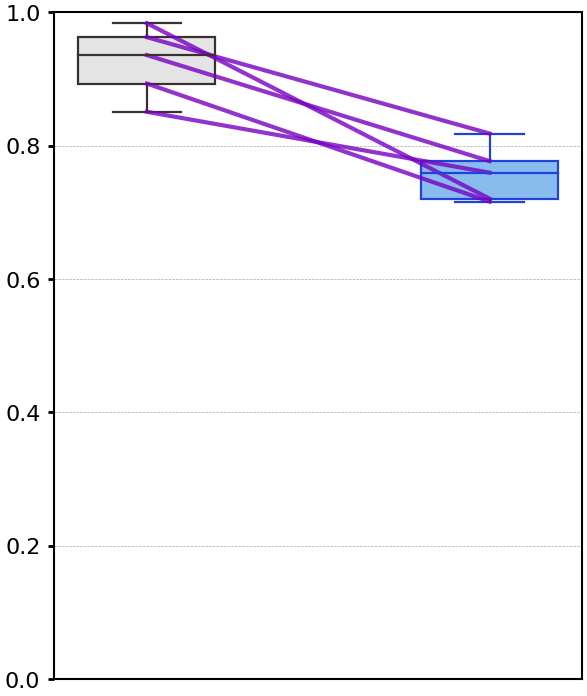

In [43]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=fr_reduction_info.expmt('swi').prb('NNXr'), 
            x='store', y='fr_reduction', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=fr_reduction_info.expmt('swi').prb('NNXo'), 
            x='store', y='fr_reduction', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=fr_reduction_info.expmt('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=fr_reduction_info.expmt('swi').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=fr_reduction_info.expmt('swi').sort_values('store', ascending=False), x='store', y='fr_reduction', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=6, alpha=0.8)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 1)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(fr_reduction_info.expmt('swi').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=12)

f.savefig('./plots/acr_fr_reduction.png', dpi=300, bbox_inches='tight')

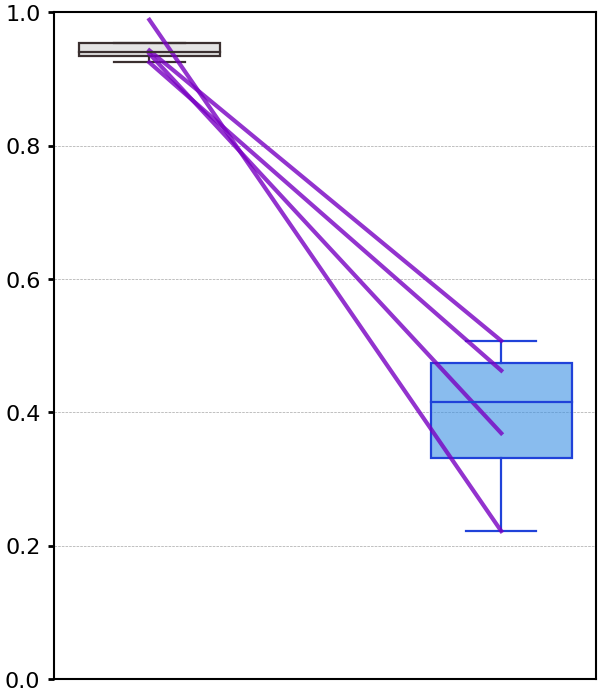

In [122]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=fr_reduction_info.expmt('swisin').prb('NNXr'), 
            x='store', y='fr_reduction', 
            order=['NNXr', 'NNXo'], 
            palette=['lightgray'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#3b3030", "linewidth": 3.2},
            whiskerprops={"color": "#3b3030", "linewidth": 3.2},
            capprops={"color": "#3b3030", "linewidth": 3.2},
            boxprops={"edgecolor": "#3b3030", "linewidth": 3.2},)

sns.boxplot(
            data=fr_reduction_info.expmt('swisin').prb('NNXo'), 
            x='store', y='fr_reduction', 
            order=['NNXr', 'NNXo'], 
            palette=['dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#2042d9", "linewidth": 3.2},
            whiskerprops={"color": "#2042d9", "linewidth": 3.2},
            capprops={"color": "#2042d9", "linewidth": 3.2},
            boxprops={"edgecolor": "#2042d9", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

#sns.swarmplot(data=fr_reduction_info.expmt('swisin'), x='store', y='fr_reduction', order=['NNXr', 'NNXo'], palette=['#202223', 'blue'], marker='o', size=15, ax=ax, alpha=0.4)
#sns.lineplot(data=fr_reduction_info.expmt('swisin').sort_values('store', ascending=False), x='store', y='Bandpower', units='subject', estimator=None, color='#0175b9', ax=ax, linewidth=4.5, alpha=0.7)
sns.lineplot(data=fr_reduction_info.expmt('swisin').sort_values('store', ascending=False), x='store', y='fr_reduction', units='subject', estimator=None, color='#7800c2', ax=ax, linewidth=6, alpha=0.8)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 1)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
num_subs = len(fr_reduction_info.expmt('swisin').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swisin_pval}', fontsize=12)

f.savefig('./plots/acr_fr_reduction_swisin.png', dpi=300, bbox_inches='tight')

In [51]:
fr_red_swi_nnxr = fr_reduction_info.expmt('swi').prb('NNXr').sort_values('subject')['fr_reduction'].to_numpy()
fr_red_swi_nnxo = fr_reduction_info.expmt('swi').prb('NNXo').sort_values('subject')['fr_reduction'].to_numpy()
swi_stats = pg.ttest(fr_red_swi_nnxr, fr_red_swi_nnxo, paired=True)
print(f'swi p-value: {swi_stats["p-val"].values[0]}')
fr_red_swisin_nnxr = fr_reduction_info.expmt('swisin').prb('NNXr').sort_values('subject')['fr_reduction'].to_numpy()
fr_red_swisin_nnxo = fr_reduction_info.expmt('swisin').prb('NNXo').sort_values('subject')['fr_reduction'].to_numpy()
swisin_stats = pg.ttest(fr_red_swisin_nnxr, fr_red_swisin_nnxo, paired=True)
print(f'swisin p-value: {swisin_stats["p-val"].values[0]}')

swi p-value: 0.003951833074829601
swisin p-value: 0.005070006644805125


# BP/FR METRIC

In [74]:
reb_df = acr.io.read_full_df(folder='rebound_data_1h')
reb_df = reb_df.sort_values('subject')

In [75]:
reb_df = reb_df.exp_names()

In [76]:
delta_exp = reb_df.loc[reb_df['Band']=='delta'].st('NREM').loc[reb_df['exp_type'] == 'acr']
delta_exp_means = delta_exp.groupby(['subject', 'exp', 'store'])['Bandpower'].mean().to_frame().reset_index()

In [72]:
sub_exp_combos = []
for sub in fr_reduction_info['subject'].unique():
    for exp in fr_reduction_info.loc[fr_reduction_info['subject'] == sub]['exp'].unique():
        sub_exp_combos.append((sub, exp))

In [91]:
fr_reduction_info.loc[(fr_reduction_info.subject == subject) & (fr_reduction_info.exp == exp) & (fr_reduction_info.store == 'NNXr')]['fr_reduction'].values[0]

0.8931872463972161

In [92]:
ix = 0
met_master = pd.DataFrame(columns=['subject', 'exp', 'swa_met'])
for subject, exp in sub_exp_combos:
    print(f'working on {subject} {exp}')
    nnxr_delta = delta_exp_means.sbj(sub).expmt(exp).prb('NNXr')['Bandpower'].values[0]
    nnxo_delta = delta_exp_means.sbj(sub).expmt(exp).prb('NNXo')['Bandpower'].values[0]
    delta_ratio = nnxo_delta/nnxr_delta
    delta_reduction = 1-delta_ratio
    nnxo_rate = fr_reduction_info.loc[(fr_reduction_info.subject == subject) & (fr_reduction_info.exp == exp) & (fr_reduction_info.store == 'NNXo')]['fr_reduction'].values[0]
    nnxr_rate = fr_reduction_info.loc[(fr_reduction_info.subject == subject) & (fr_reduction_info.exp == exp) & (fr_reduction_info.store == 'NNXr')]['fr_reduction'].values[0]
    fr_ratio = nnxo_rate/nnxr_rate
    fr_reduction = 1-fr_ratio
    swa_met = delta_reduction/fr_reduction
    print(swa_met)
    swa_met_df = pd.DataFrame({'subject': subject, 'exp': exp, 'swa_met': swa_met}, index=[ix])
    met_master = pd.concat([met_master, swa_met_df])
    ix += 1

working on ACR_17 swi
0.713059493432603
working on ACR_18 swi
0.5283965920075626
working on ACR_18 swisin
0.22120295534567638
working on ACR_19 swi
0.9417398801747733
working on ACR_19 swisin
0.3433800833675113
working on ACR_20 swi
0.8322025411079782
working on ACR_20 swisin
0.37152167669266384
working on ACR_23 swi
1.316925736992304
working on ACR_23 swisin
0.28270025173147045


In [45]:
met_master.drop(1, inplace=True)
met_master.drop(5, inplace=True)

met_master.loc[met_master.exp == 'swi2', 'exp'] = 'swi'

/tmp/ipykernel_863957/434331195.py:35: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=met_master, x='exp', y='swa_met', order=['swi', 'swisin'], palette=['#7800c2', '#7800c2'], marker='o', size=25, ax=ax, alpha = 0.9)


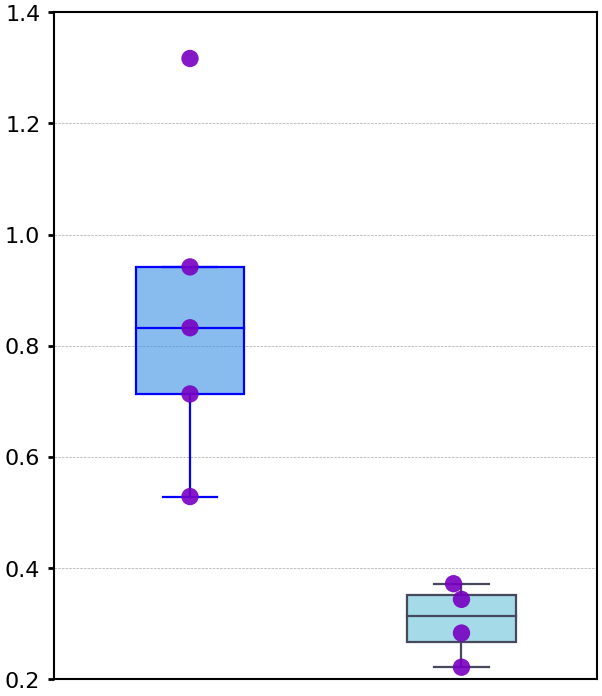

In [128]:
f, ax = plt.subplots(1, 1, figsize=(13, 15), sharey=True)

# OFF-INDUCTION
sns.boxplot(
            data=met_master.expmt('swi'), 
            x='exp', y='swa_met', 
            order=['swi', 'swisin'], 
            palette=['dodgerblue'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "blue", "linewidth": 3.2},
            whiskerprops={"color": "blue", "linewidth": 3.2},
            capprops={"color": "blue", "linewidth": 3.2},
            boxprops={"edgecolor": "blue", "linewidth": 3.2},)

sns.boxplot(
            data=met_master.expmt('swisin'), 
            x='exp', y='swa_met', 
            order=['swi', 'swisin'], 
            palette=['#57cfed'], 
            fliersize=0, 
            ax=ax, 
            width=0.4,
            medianprops={"color": "#46485d", "linewidth": 3.2},
            whiskerprops={"color": "#46485d", "linewidth": 3.2},
            capprops={"color": "#46485d", "linewidth": 3.2},
            boxprops={"edgecolor": "#46485d", "linewidth": 3.2},)

plt.tight_layout()
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.6))

sns.swarmplot(data=met_master, x='exp', y='swa_met', order=['swi', 'swisin'], palette=['#7800c2', '#7800c2'], marker='o', size=25, ax=ax, alpha = 0.9)

ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.2, 1.4)
#ax.axhline(1, color='red', linestyle='--', linewidth=4)
#num_subs = len(met_master.expmt('swi').subject.unique())
#f.suptitle(f'SWA During 1-Hour NREM Rebound (Delta), ACR ANIMALS ONLY | (N={num_subs}) | p={swi_pval}', fontsize=12)

f.savefig('./plots/SWA_MET.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_863957/3466598015.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=met_master, x='exp', y='swa_met', order=['swi', 'swisin'], palette=['blue', 'blue'], marker='o', size=18, ax=ax)


Text(0.5, 0.98, 'Sleep Pressure Released per MUA Firing Rate Reduction')

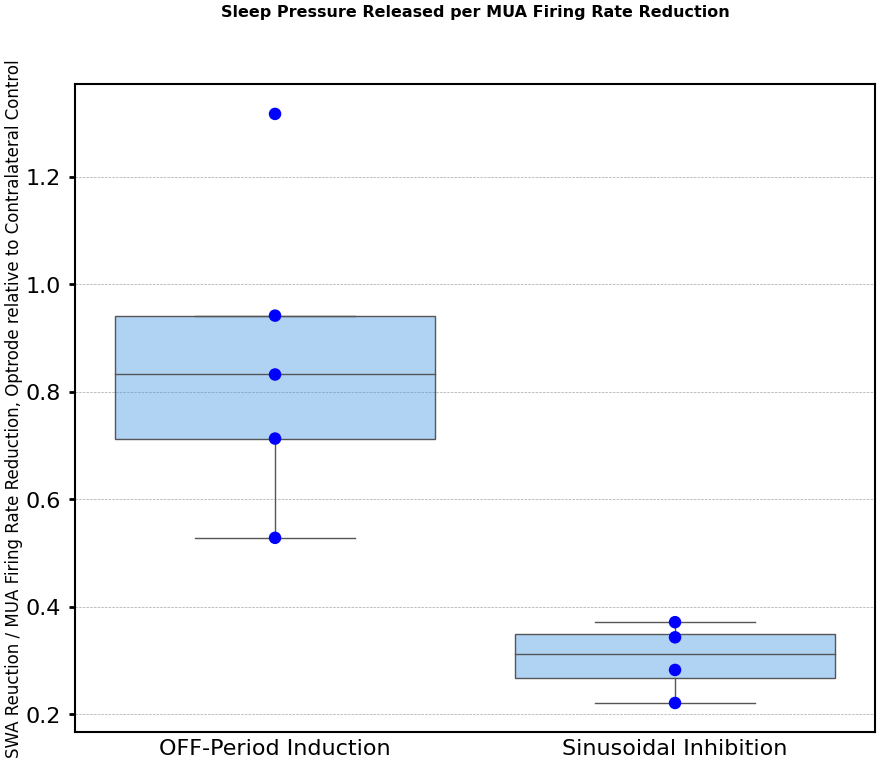

In [94]:
f, ax = plt.subplots(figsize=(20, 16))
sns.boxplot(data=met_master, x='exp', y='swa_met', order=['swi', 'swisin'], palette=['dodgerblue', 'dodgerblue'], fliersize=0, ax=ax)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=met_master, x='exp', y='swa_met', order=['swi', 'swisin'], palette=['blue', 'blue'], marker='o', size=18, ax=ax)
#sns.lineplot(data=met_master, x='exp', y='swa_met', units='subject', estimator=None, color='teal', ax=ax, linewidth=3)

ax.set_xticklabels(['OFF-Period Induction', 'Sinusoidal Inhibition'])
ax.set_xlabel('')
#ax[1].set_title('Sinusoidal', fontsize=24)
ax.set_ylabel('')


# FIGURE-LEVEL
f.suptitle('Sleep Pressure Released per MUA Firing Rate Reduction')

In [95]:
swi_met = met_master.expmt('swi')['swa_met'].to_numpy()
swisin_met = met_master.expmt('swisin')['swa_met'].to_numpy()

In [96]:
pg.ttest(swi_met, swisin_met, paired=False)

T       dof alternative     p-val        CI95%   cohen-d  \
T-test  4.130501  4.506372   two-sided  0.011309  [0.2, 0.92]  2.473726   

         BF10     power  
T-test  9.083  0.883309

# Raw Data Examples

In [397]:
subject = 'ACR_23'
exp = 'swisin'
params = acr.info_pipeline.subject_params(subject)
stores = params['time_stores']
sort_ids = [f'{exp}-{store}' for store in stores]

df, idf = acr.pl_units.load_spikes_polars(subject, sort_ids, info=True, exclude_bad_units=True)

In [398]:
h = acr.io.load_hypno_full_exp(subject, exp)
si = acr.info_pipeline.load_subject_info(subject)
params = acr.info_pipeline.subject_params(subject)
stores = params['time_stores']
sort_ids = [f'{exp}-{store}' for store in stores]
recordings = acr.info_pipeline.get_exp_recs(subject, exp)

# load some temporal information about the rebound, baseline, sd, etc. 
stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
reb_start = h.hts(stim_end-pd.Timedelta('15min'), stim_end+pd.Timedelta('1h')).st('NREM').iloc[0].start_time
if reb_start < stim_end:
    stim_end_hypno = h.loc[(h.start_time<stim_end)&(h.end_time>stim_end)] # if stim time is in the middle of a nrem bout, then it can be the start of the rebound
    if stim_end_hypno.state.values[0] == 'NREM':
        reb_start = stim_end
    else:
        raise ValueError('Rebound start time is before stim end time, need to inspect')
assert reb_start >= stim_end, 'Rebound start time is before stim end time'
bl_start_actual = si["rec_times"][f'{exp}-bl']["start"]
bl_day = bl_start_actual.split("T")[0]
bl_start = pd.Timestamp(bl_day + "T09:00:00")
if f'{exp}-sd' in si['rec_times'].keys():
    sd_rec = f'{exp}-sd'
    sd_end = pd.Timestamp(si['rec_times'][sd_rec]['end'])
else:
    sd_rec = exp
    sd_end = stim_start
sd_start_actual = pd.Timestamp(si['rec_times'][sd_rec]['start'])
sd_day = si['rec_times'][sd_rec]['start'].split("T")[0]
sd_start = pd.Timestamp(sd_day + "T09:00:00")

[autoreload of sub_params failed: Traceback (most recent call last):
  File "/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'sub_params'
]
[autoreload of sub_params failed: Traceback (most recent call last):
  File "/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/si

In [399]:
ons, offs = acr.stim.get_individual_pulse_times(subject, exp, 'Wavt')

In [ ]:
n = 0
eff_ons = []
eff_offs = []
eff_lens = []
for on, off in zip(ons[1800:2700], offs[1800:2700]):
    if n >=20:
        break
    if len(df.ts(on, off).prb('NNXo')) < 1:
        print(f'ON: {on}, OFF: {off}')
        n += 1
        eff_ons.append(on)
        eff_offs.append(off)
        eff_lens.append(len(df.ts(on, off).prb('NNXo')))

In [103]:
td = np.timedelta64(150, 'ms')

In [400]:
# Sinusoidal Data
trial = 1
td_sin = np.timedelta64(750, 'ms')
t_arrays_o = []
spike_arrays_o = []
for on in ons:
    t = np.array(df.ts(on-td_sin, on+(td_sin*2)).prb('NNXo')['datetime'].to_numpy())
    tds = (t-on)/np.timedelta64(1, 'ms')
    spike_marks = np.ones(len(tds))*trial
    trial += 1
    t_arrays_o.append(tds)
    spike_arrays_o.append(spike_marks)

In [401]:
# Sinusoidal Data
trial = 1
td_sin = np.timedelta64(750, 'ms')
t_arrays_r = []
spike_arrays_r = []
for on in ons:
    t = np.array(df.ts(on-td_sin, on+(td_sin*2)).prb('NNXr')['datetime'].to_numpy())
    tds = (t-on)/np.timedelta64(1, 'ms')
    spike_marks = np.ones(len(tds))*trial
    trial += 1
    t_arrays_r.append(tds)
    spike_arrays_r.append(spike_marks)

In [145]:
trial = 1
t_arrays_o = []
spike_arrays_o = []
for eff_on, eff_off in zip(eff_ons, eff_offs):
    t = np.array(df.ts(eff_on-td, eff_off+td).prb('NNXo')['datetime'].to_numpy())
    start = eff_on
    tds = (t-start)/np.timedelta64(1, 'ms')
    spike_marks = np.ones(len(tds))*trial
    trial += 1
    t_arrays_o.append(tds)
    spike_arrays_o.append(spike_marks)

In [146]:
trial = 1
t_arrays_r = []
spike_arrays_r = []
for eff_on, eff_off in zip(eff_ons, eff_offs):
    t = np.array(df.ts(eff_on-td, eff_off+td).prb('NNXr')['datetime'].to_numpy())
    start = eff_on
    tds = (t-start)/np.timedelta64(1, 'ms')
    spike_marks = np.ones(len(tds))*trial
    trial += 1
    t_arrays_r.append(tds)
    spike_arrays_r.append(spike_marks)

# MUA Spiking During OFF-Induction

Text(0.5, 0.98, 'MUA Spiking During OFF-Period Induction')

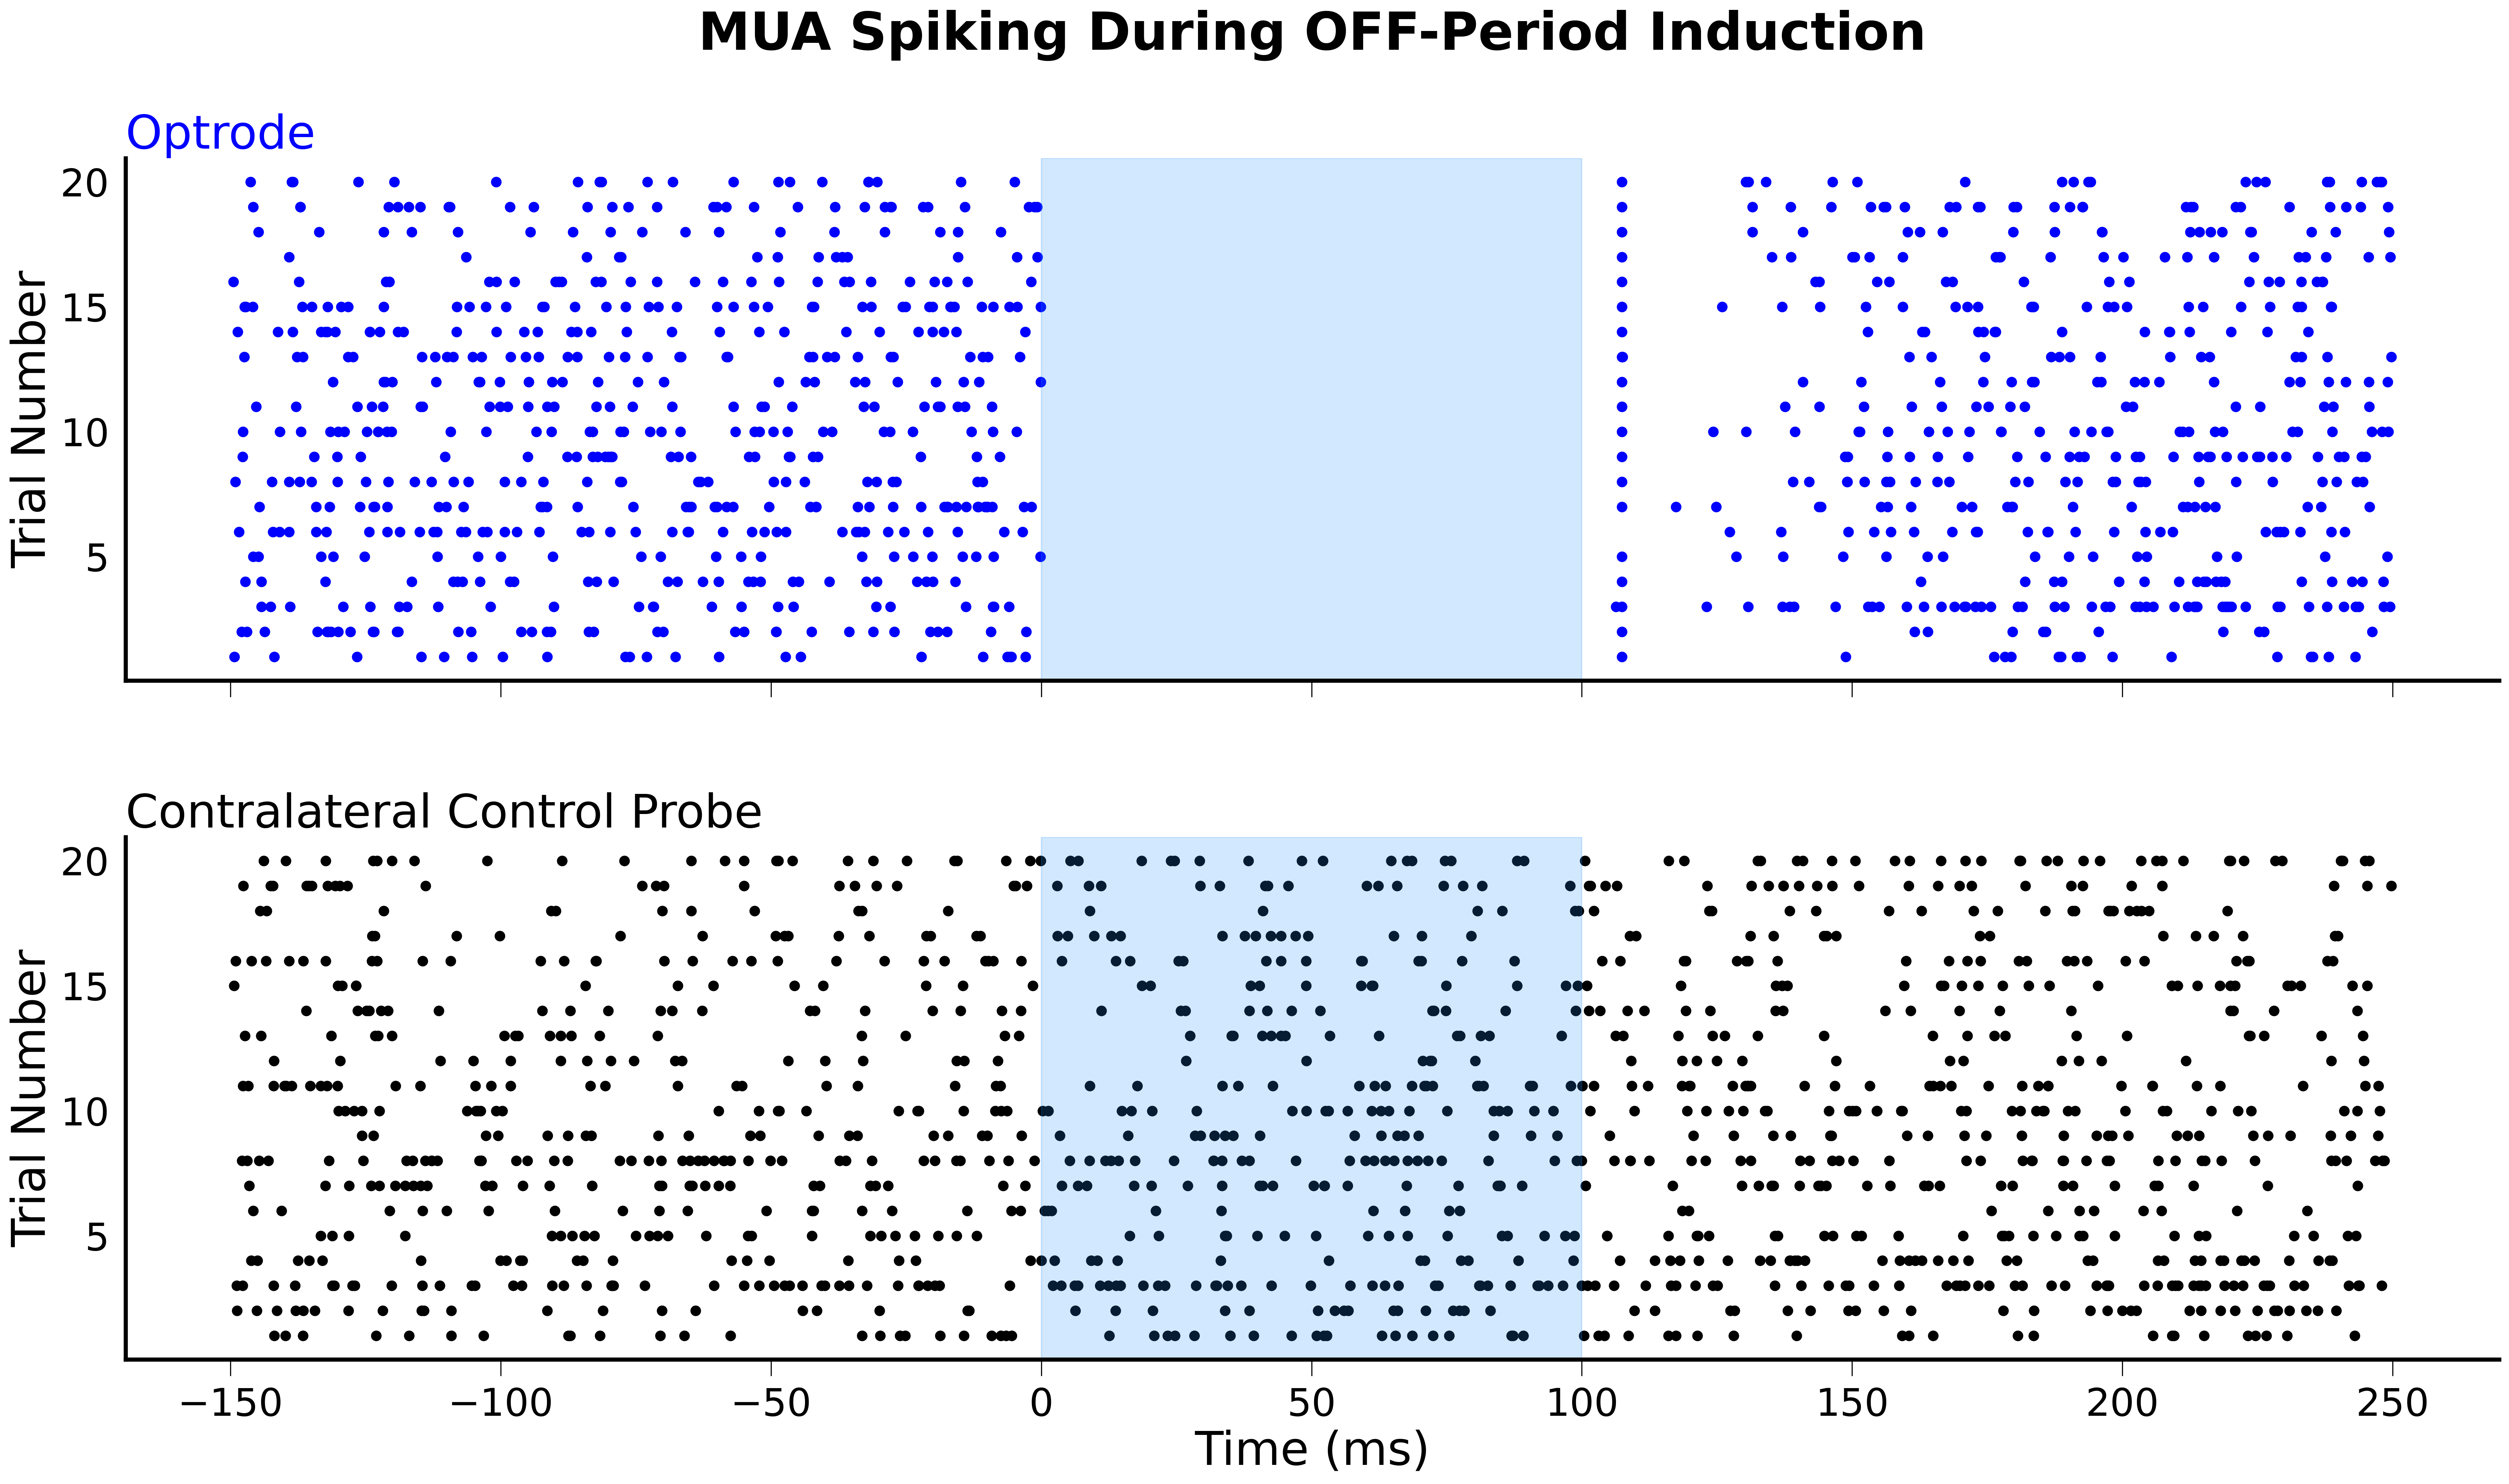

In [271]:
f, ax = plt.subplots(2, 1, figsize = (30, 15), sharex=True)
for t, spikes in zip(t_arrays_o, spike_arrays_o):
    ax[0].scatter(t, spikes, s=45, color='blue',)
for t, spikes in zip(t_arrays_r, spike_arrays_r):
    ax[1].scatter(t, spikes, s=45, color='black')
ax[1].set_xlabel('Time (ms)')
ax[0].axvspan(0, 100, alpha=0.2, color='dodgerblue')
ax[1].axvspan(0, 100, alpha=0.2, color='dodgerblue')
ax[0].set_ylabel('Trial Number')
ax[1].set_ylabel('Trial Number')
ax[0].set_title('Optrode', color='blue')
ax[1].set_title('Contralateral Control Probe')
f.suptitle('MUA Spiking During OFF-Period Induction')

Text(0.5, 0.98, 'MUA Spiking During Constant Inhibition')

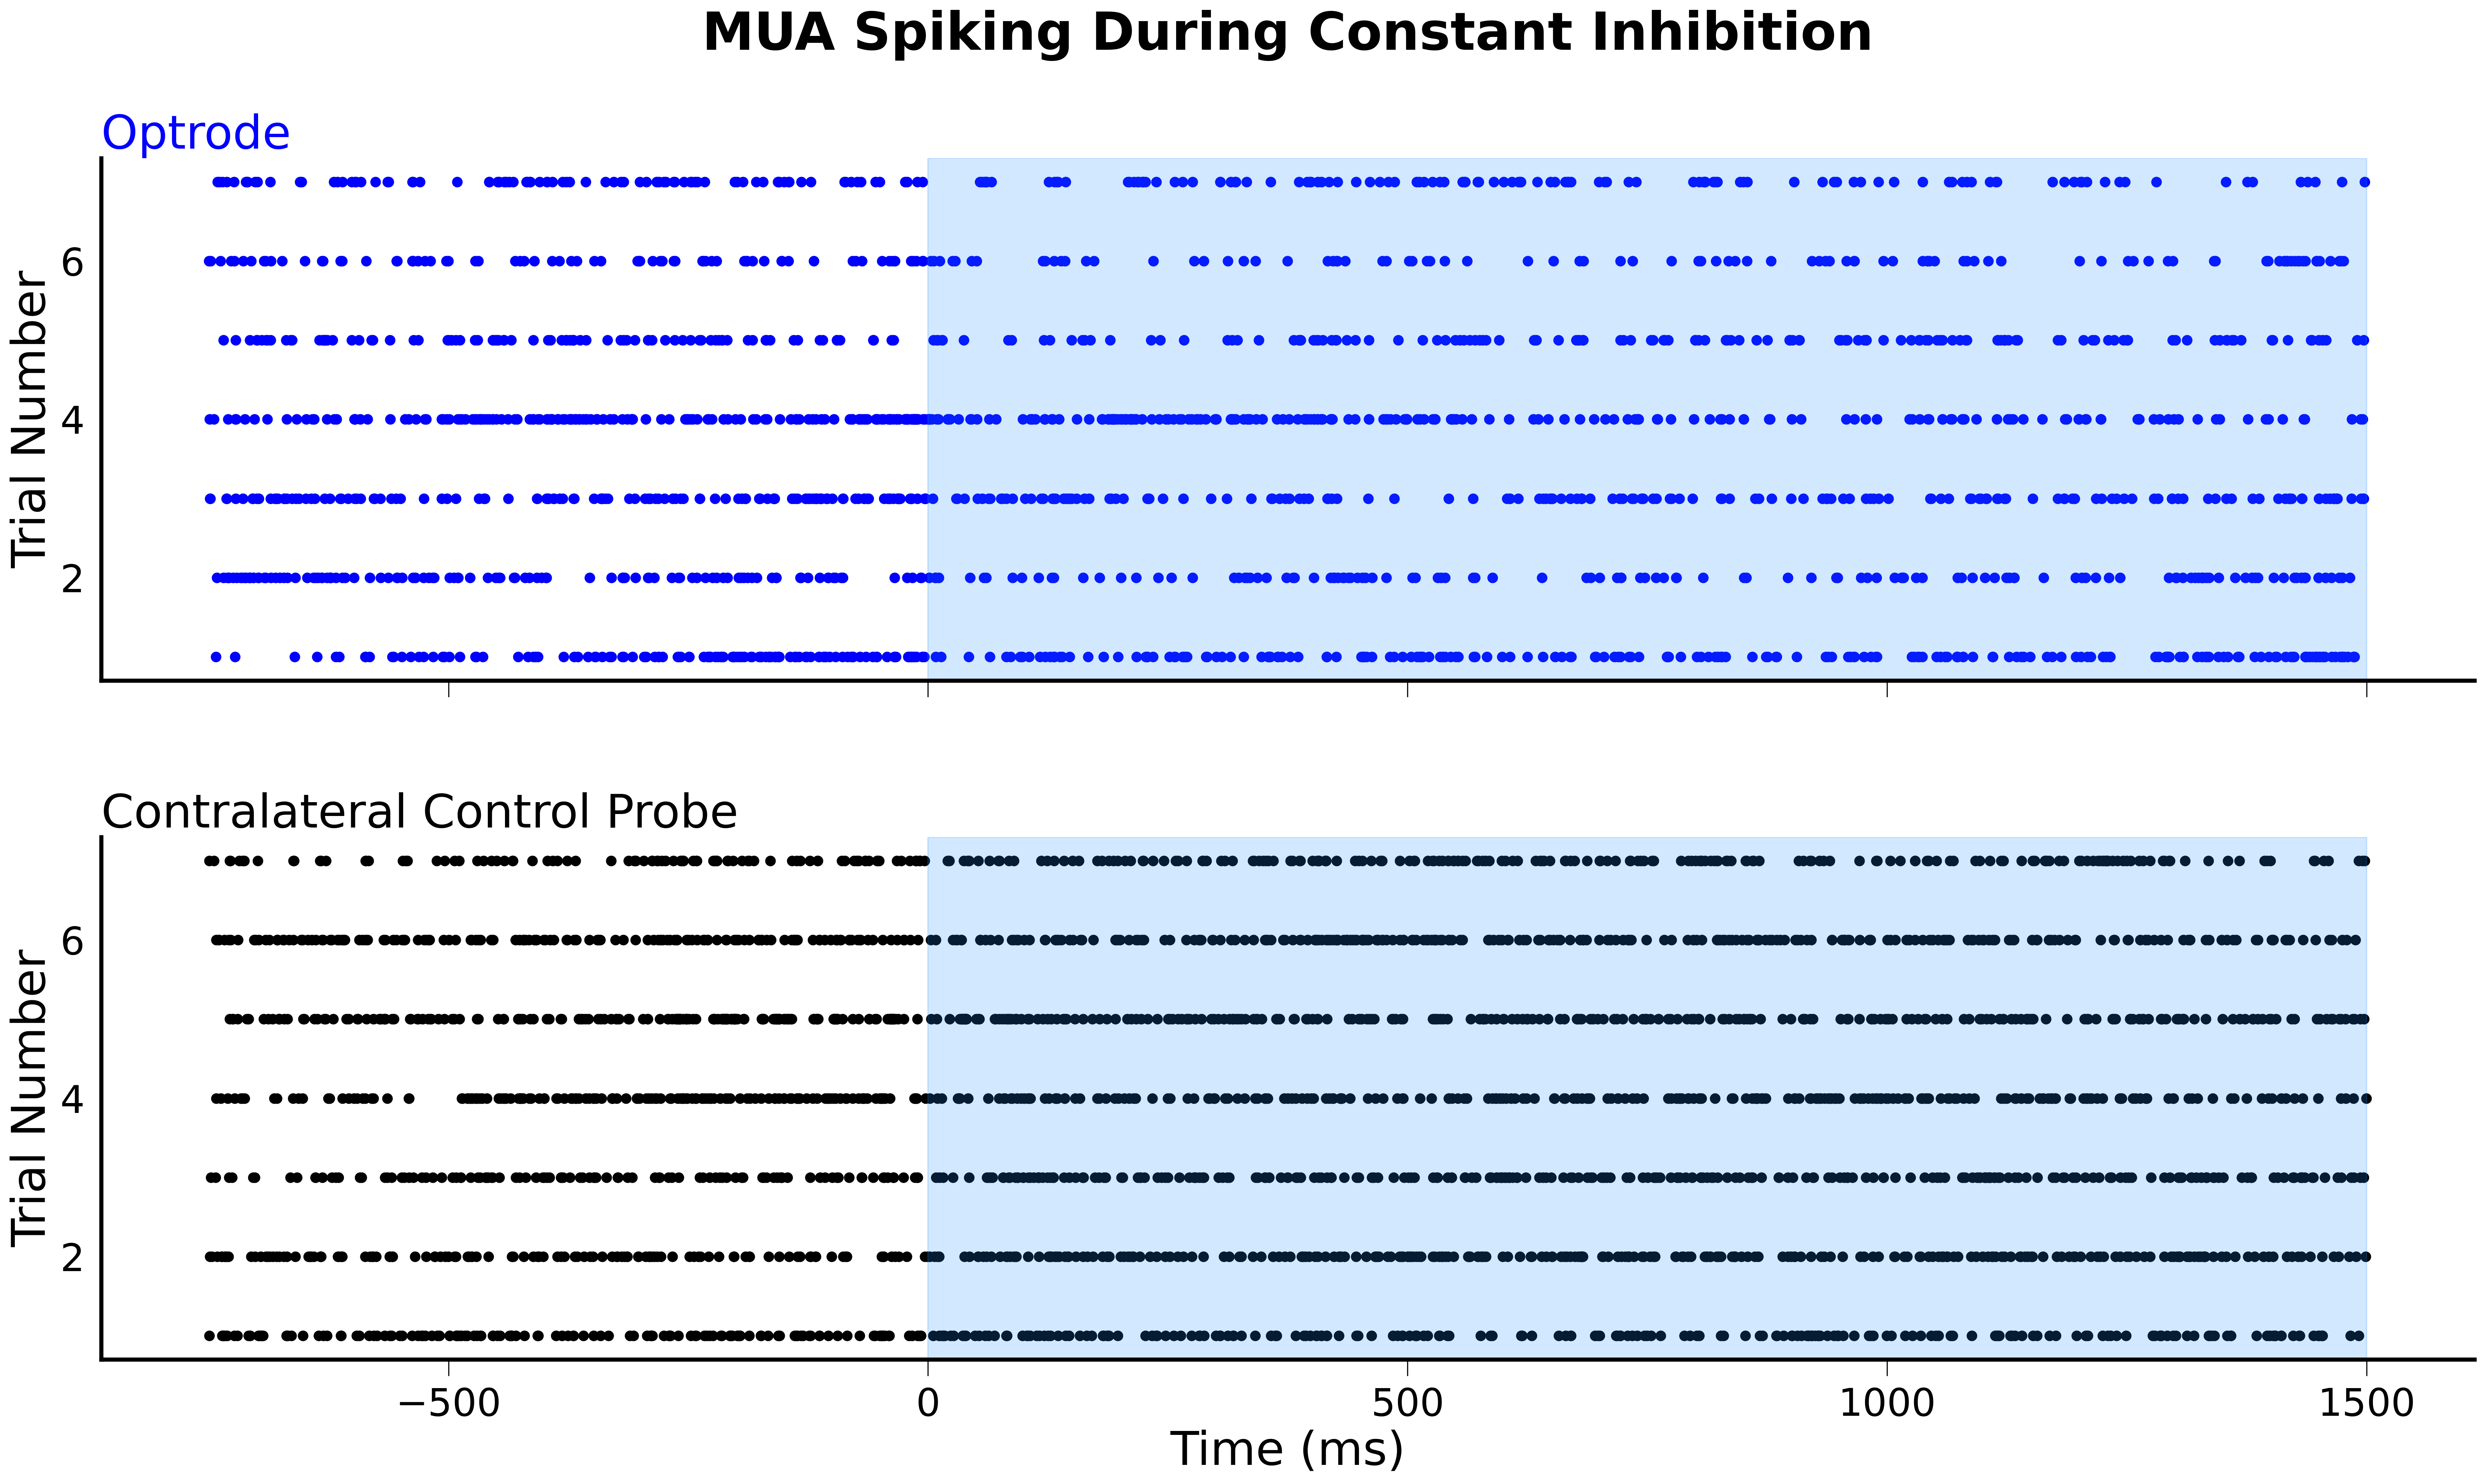

In [402]:
f, ax = plt.subplots(2, 1, figsize = (30, 15), sharex=True)
for t, spikes in zip(t_arrays_o, spike_arrays_o):
    ax[0].scatter(t, spikes, s=45, color='blue',)
for t, spikes in zip(t_arrays_r, spike_arrays_r):
    ax[1].scatter(t, spikes, s=45, color='black')

ax[1].set_xlabel('Time (ms)')
ax[0].axvspan(0, 1500, alpha=0.2, color='dodgerblue')
ax[1].axvspan(0, 1500, alpha=0.2, color='dodgerblue')
ax[0].set_ylabel('Trial Number')
ax[1].set_ylabel('Trial Number')
ax[0].set_title('Optrode', color='blue')
ax[1].set_title('Contralateral Control Probe')
f.suptitle('MUA Spiking During Constant Inhibition')

In [142]:
trial = 1
t_arrays = []
spike_arrays = []
for eff_on, eff_off in zip(eff_ons, eff_offs):
    t = np.array(df.ts(eff_on-td, eff_off+td).prb('NNXr')['datetime'].to_numpy())
    start = eff_on
    tds = (t-start)/np.timedelta64(1, 'ms')
    spike_marks = np.ones(len(tds))*trial
    trial += 1
    t_arrays.append(tds)
    spike_arrays.append(spike_marks)

In [403]:
fpo = acr.io.load_raw_data(subject, 'swisin', 'NNXo')
fpr = acr.io.load_raw_data(subject, 'swisin', 'NNXr')

In [404]:
fp_td = np.timedelta64(750, 'ms')

In [234]:
fp_list_r = []
for eon, eoff in zip(eff_ons, eff_offs):
    dat = fpr.ch(9).ts(eon-fp_td, eoff+fp_td).values
    if len(dat) > 160:
        dat = dat[:160]
    fp_list_r.append(dat)
    

In [415]:
#sinusoidal
fp_list_o = []
for on in ons:
    dat = fpo.ch(7).ts(on-fp_td, on+(fp_td*2)).values
    if len(dat) > 900:
        dat = dat[:900]
    fp_list_o.append(dat)

In [416]:
# sinusoidal
fp_list_r = []
for on in ons:
    dat = fpr.ch(7).ts(on-fp_td, on+(fp_td*2)).values
    if len(dat) > 900:
        dat = dat[:900]
    fp_list_r.append(dat)

In [347]:
fp_times = np.linspace(-150, 250, 160)

fpo_mean = np.mean(fp_list_o, axis=0)

fpo_std = np.std(fp_list_o, axis=0)


In [417]:
#sinusoidal
fp_times = np.linspace(-750, 1500, 900)

fpo_mean = np.mean(fp_list_o, axis=0)

fpo_std = np.std(fp_list_o, axis=0)


In [418]:

fpr_mean = np.mean(fp_list_r, axis=0)

fpr_std = np.std(fp_list_r, axis=0)


(-500.0, 500.0)

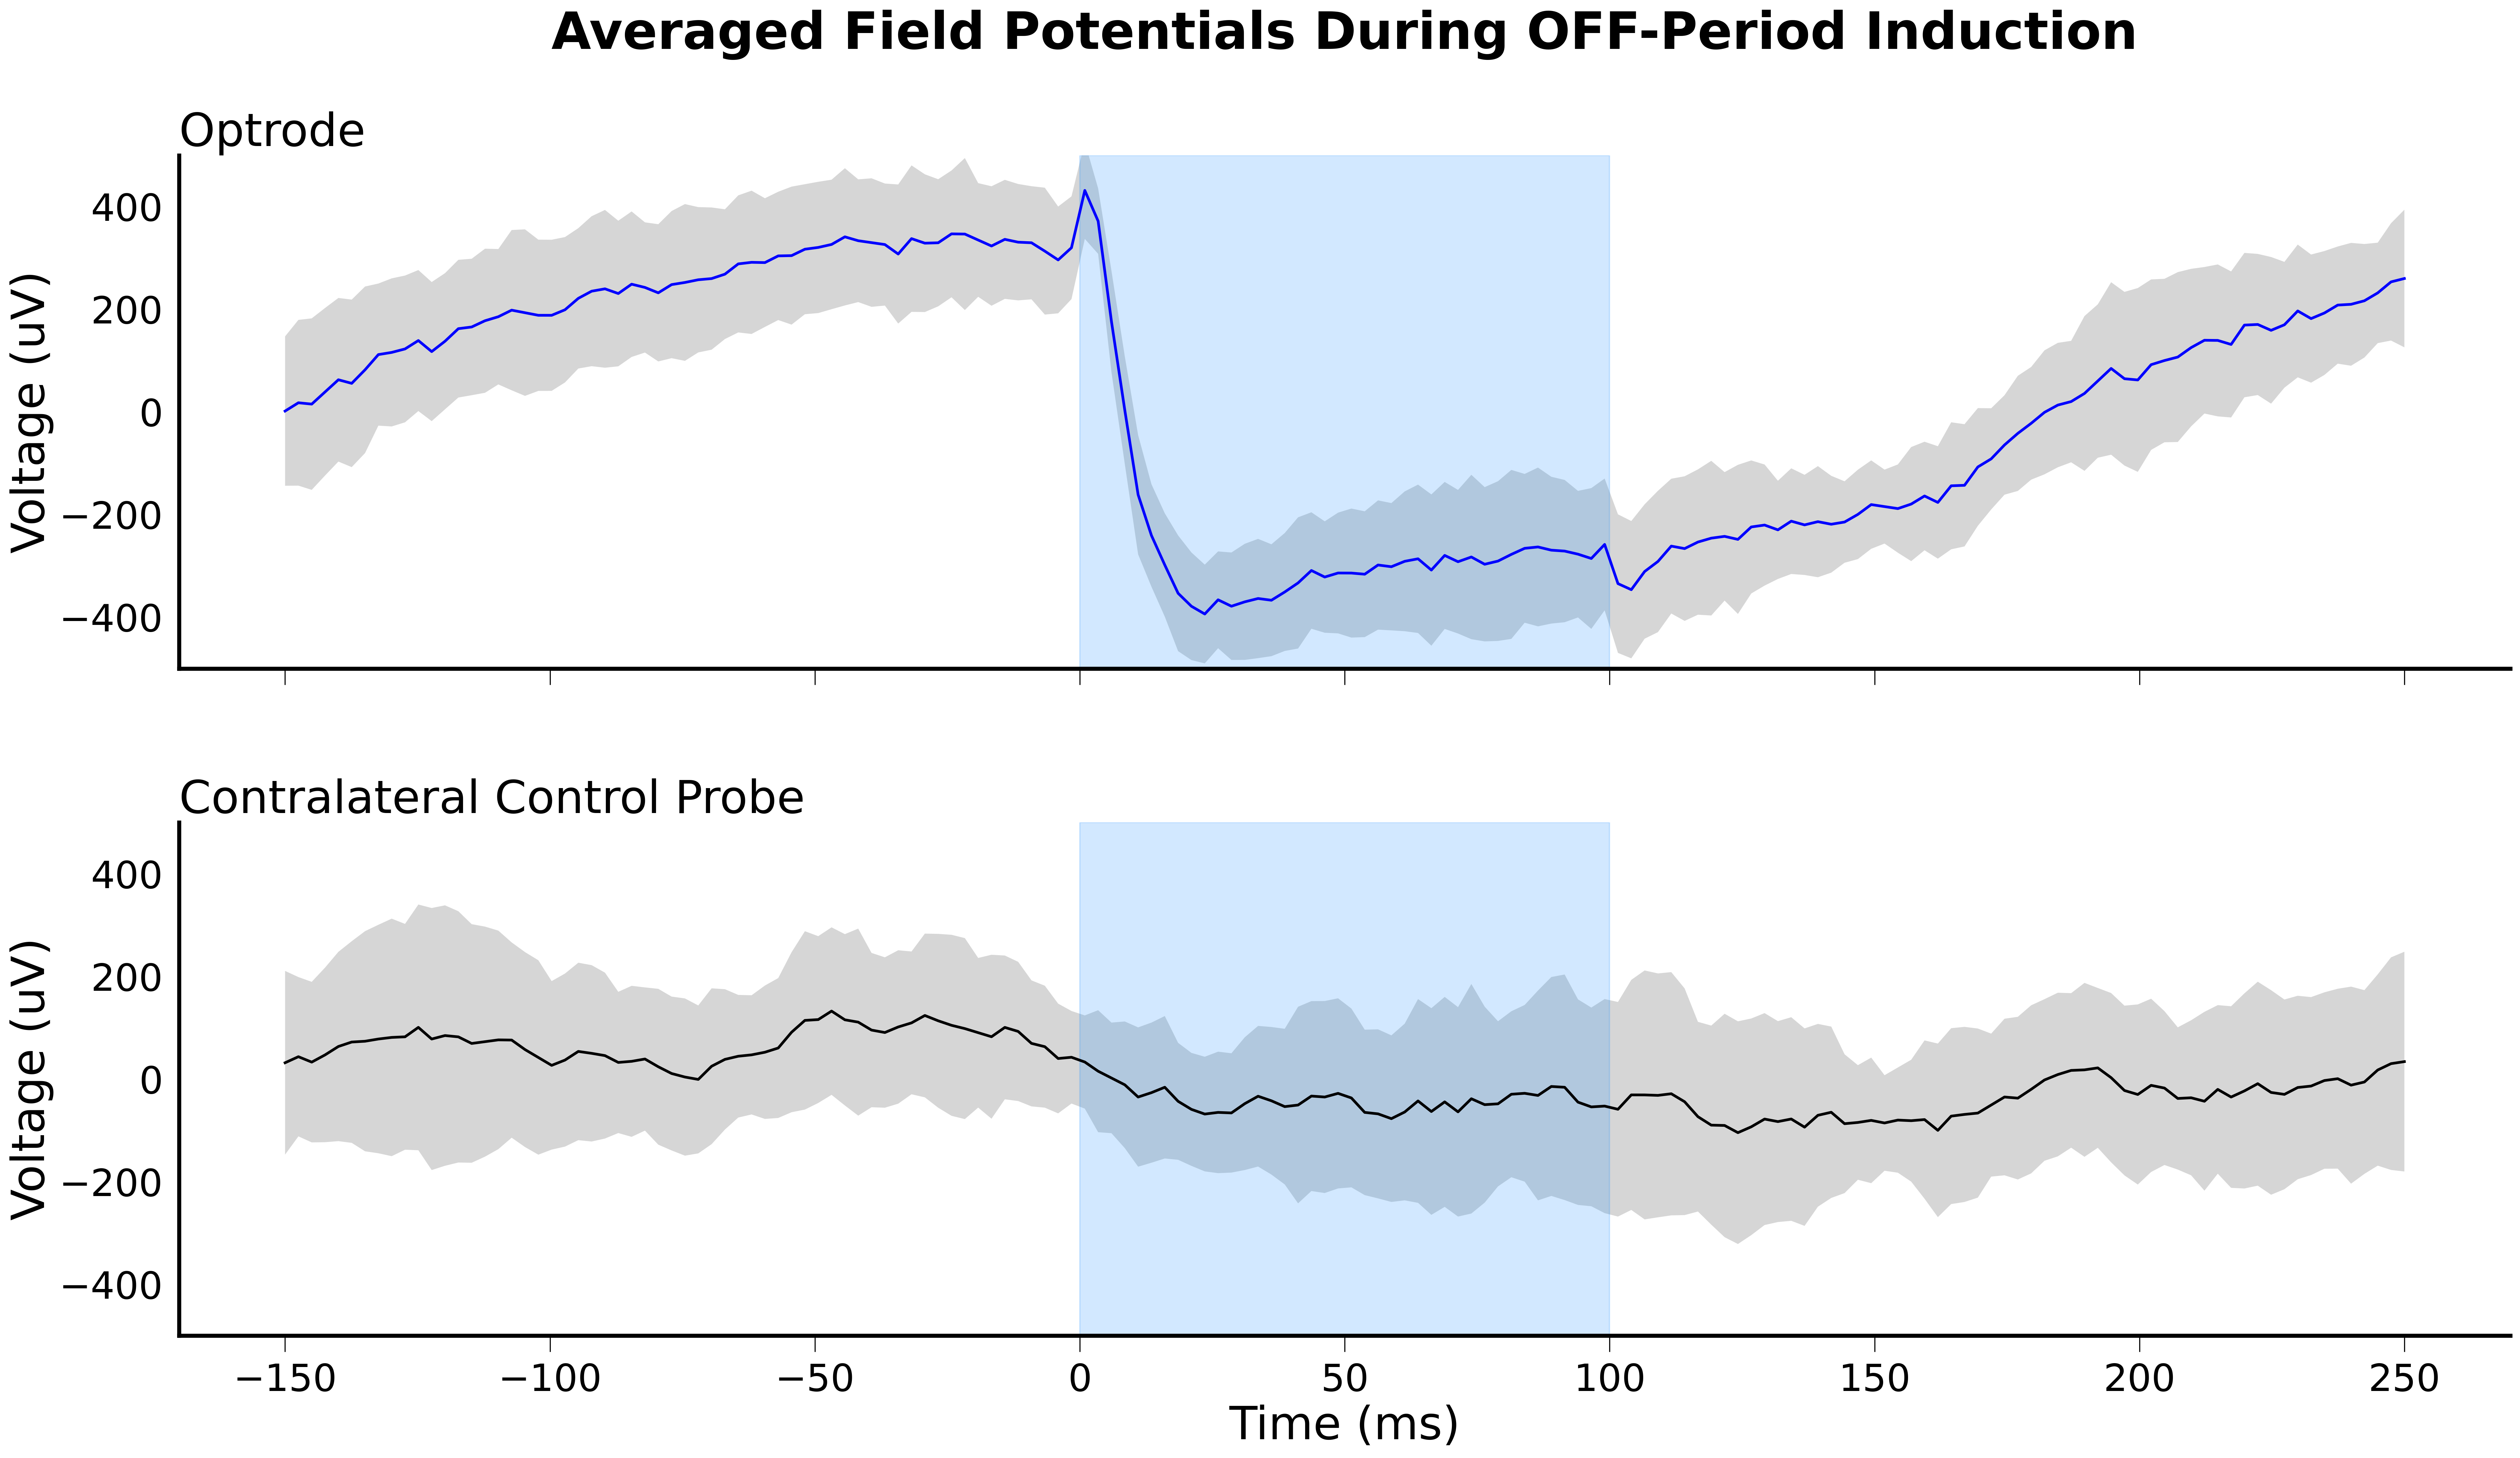

In [274]:
f, ax  = plt.subplots(2, 1, figsize=(30, 15), sharex=True)
ax[0].plot(fp_times, fpo_mean, color='Blue')
ax[0].fill_between(fp_times, fpo_mean-fpo_std, fpo_mean+fpo_std, alpha=0.2)
ax[0].axvspan(0, 100, alpha=0.2, color='dodgerblue')
ax[0].set_ylabel('Voltage (uV)')

ax[0].set_title('Optrode')


ax[1].plot(fp_times, fpr_mean, color='Black')
ax[1].fill_between(fp_times, fpr_mean-fpr_std, fpr_mean+fpr_std, alpha=0.2)
ax[1].axvspan(0, 100, alpha=0.2, color='dodgerblue')
ax[1].set_ylabel('Voltage (uV)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Contralateral Control Probe')

f.suptitle('Averaged Field Potentials During OFF-Period Induction')

ax[0].set_ylim(-500, 500)
ax[1].set_ylim(-500, 500)

(-600.0, 600.0)

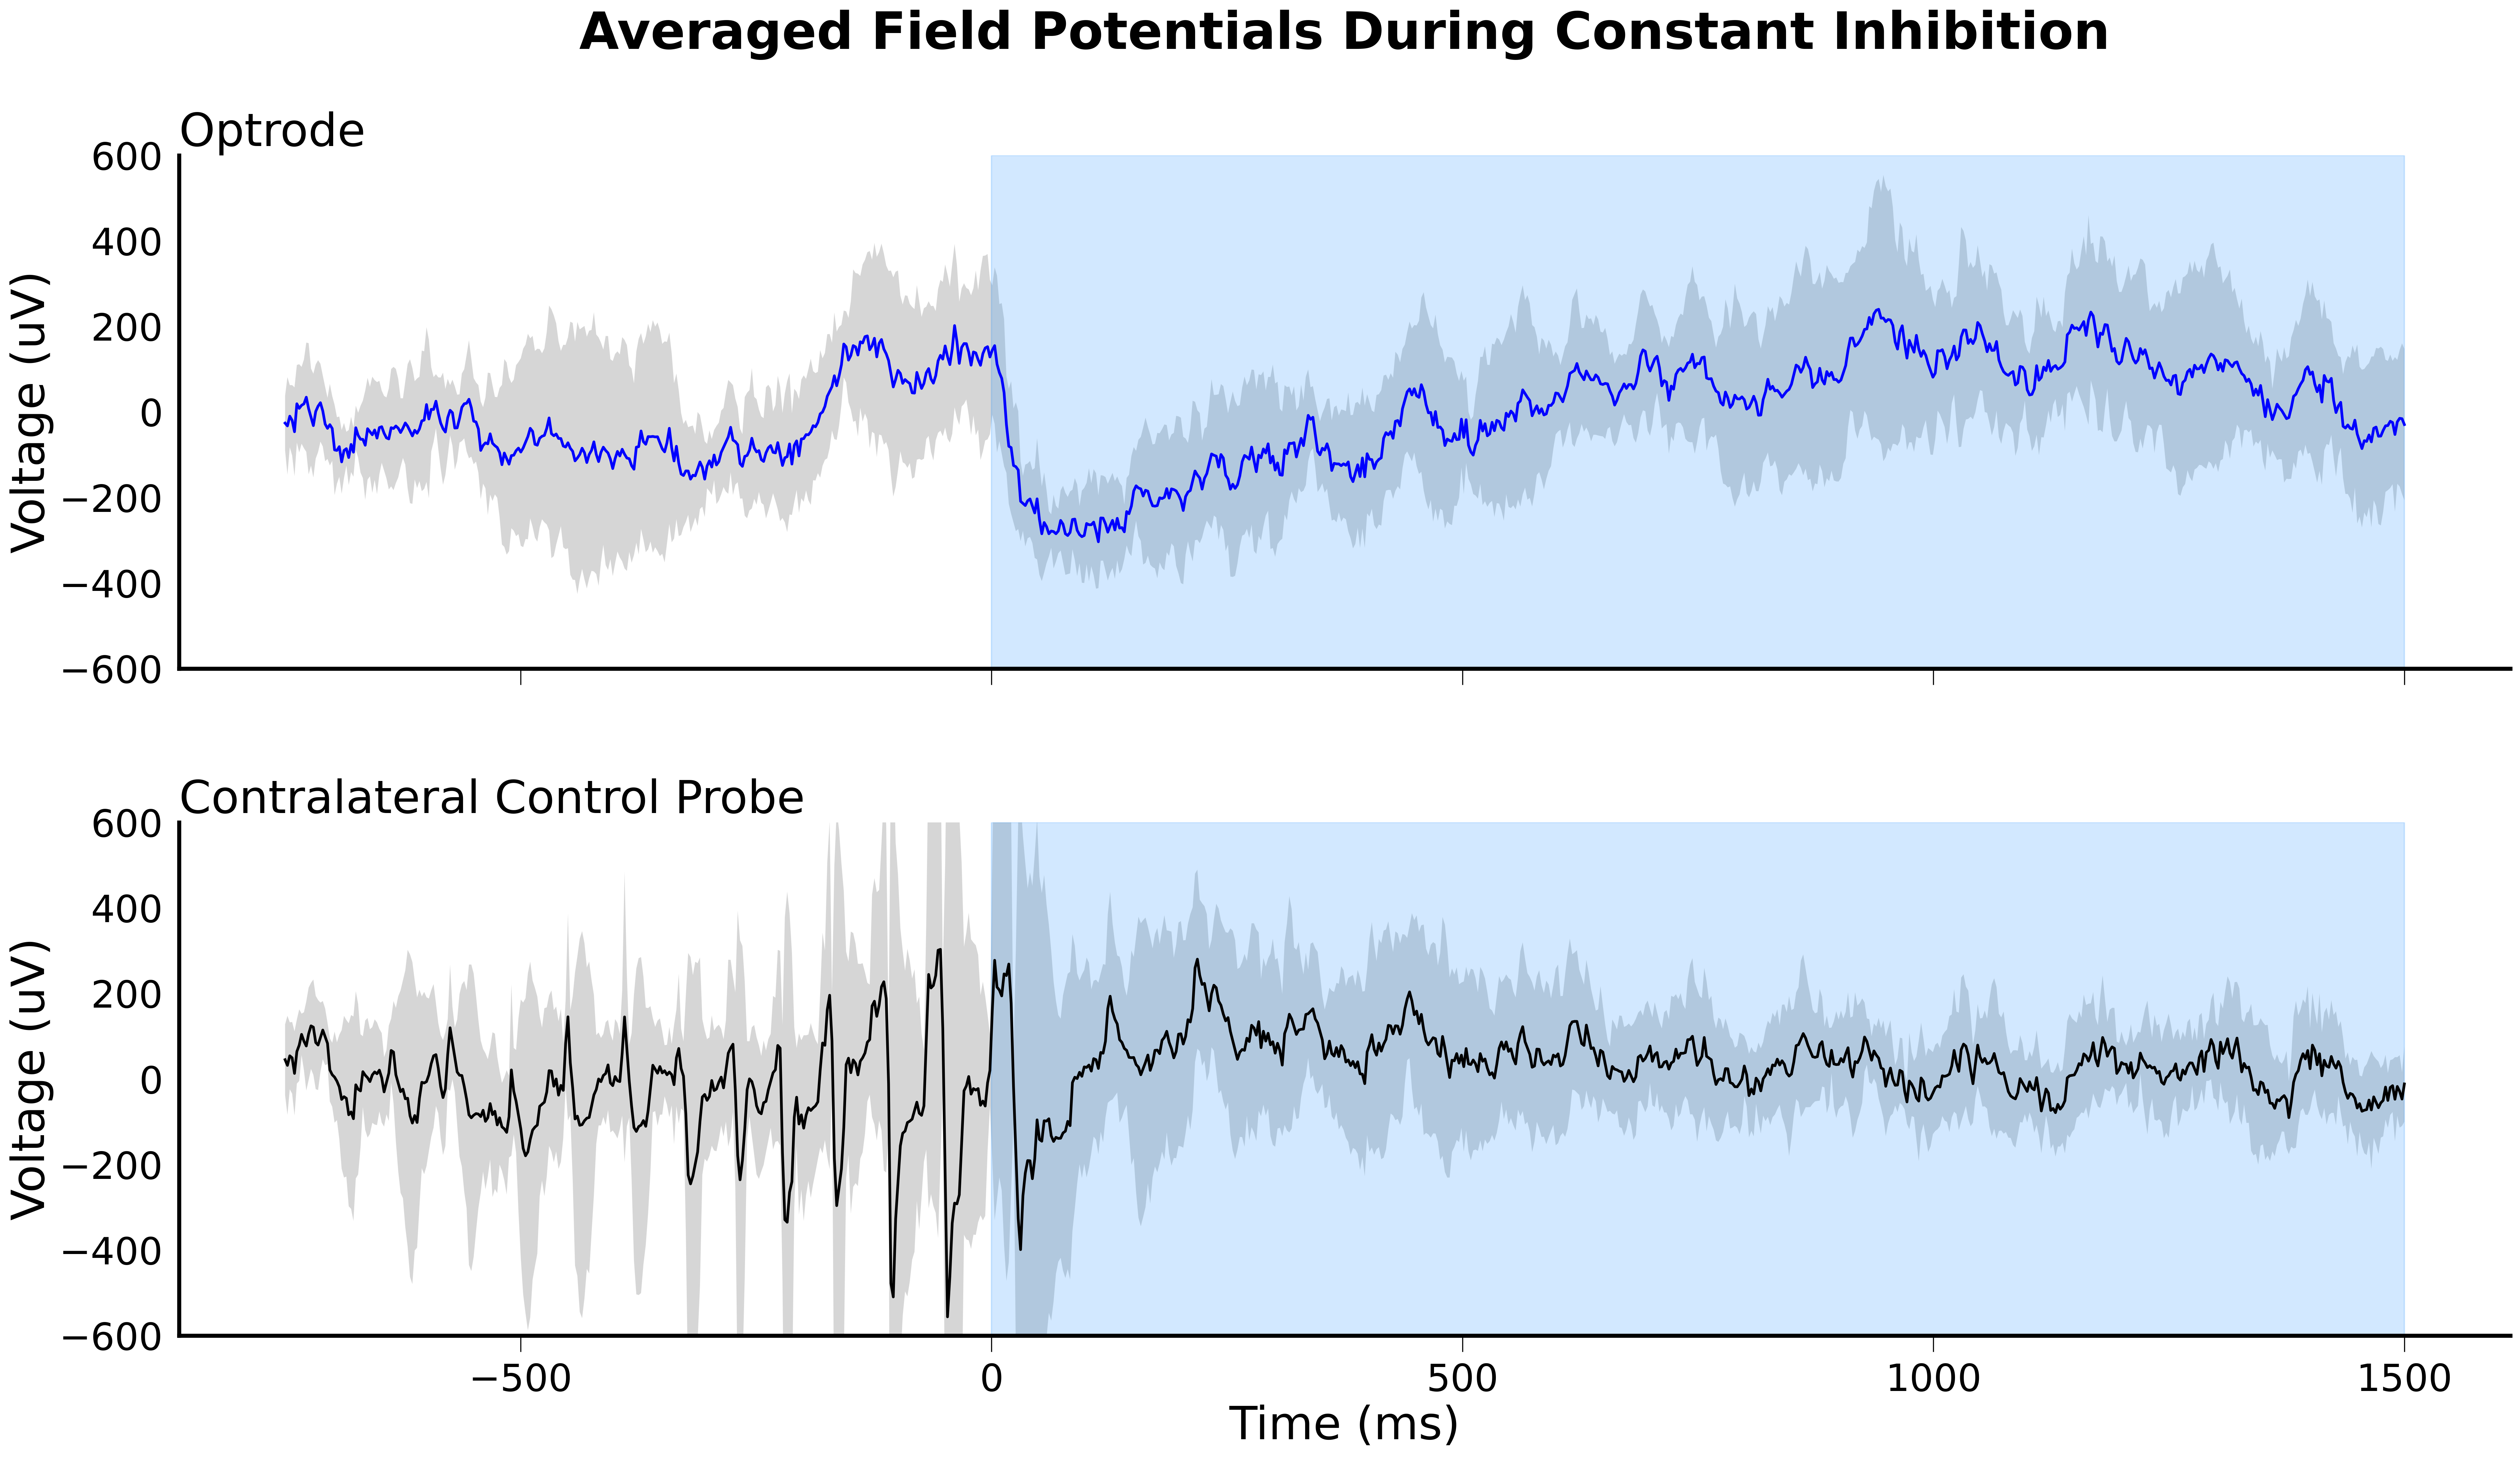

In [419]:
f, ax  = plt.subplots(2, 1, figsize=(30, 15), sharex=True)
ax[0].plot(fp_times, fpo_mean, color='Blue')
ax[0].fill_between(fp_times, fpo_mean-fpo_std, fpo_mean+fpo_std, alpha=0.2)
ax[0].axvspan(0, 1500, alpha=0.2, color='dodgerblue')
ax[0].set_ylabel('Voltage (uV)')

ax[0].set_title('Optrode')


ax[1].plot(fp_times, fpr_mean, color='Black')
ax[1].fill_between(fp_times, fpr_mean-fpr_std, fpr_mean+fpr_std, alpha=0.2)
ax[1].axvspan(0, 1500, alpha=0.2, color='dodgerblue')
ax[1].set_ylabel('Voltage (uV)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Contralateral Control Probe')

f.suptitle('Averaged Field Potentials During Constant Inhibition')

ax[0].set_ylim(-600, 600)
ax[1].set_ylim(-600, 600)